# Lab 3 - Finite State Machines (FSM)

## Task 1 - 4-bit LFSR and Pseudo Random Binary Sequence

### Step 1 - create the component lfsr.sv
> Create the component `lfsr.sv` guided by Lecture 4. <br>
> Modify the version to include an extra enable signal `en`, and all four bits of the shift reggister output are bought out as `data_out[3:0]`

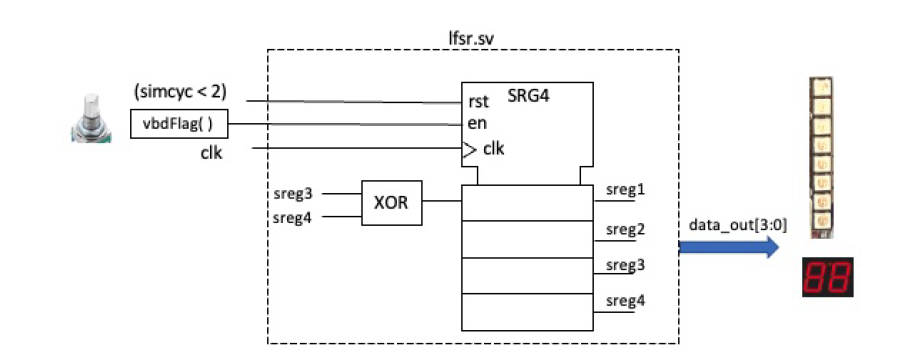

`lfsr.sv`
```systemverilog
module lfsr (
    input logic         clk, 
    input logic         rst,
    input               en,  
    output logic [3:0]  data_out
);
    logic [3:0] sreg;

    always_ff @(posedge clk, posedge rst)   begin 
        if (rst)
            sreg <= 4'b1; 
        else
            if (en) sreg <= {sreg[2:0], sreg[3]^sreg[2]};
    end 

    assign data_out = sreg;
endmodule

```

### Step 2 - Create the testbench for the LFSR
> Create a testbench to test this 4-bit random number generator. <br><br>
> In the testbench you should use the Vbuddy rotary encoder switch (EC11) and the `vbdFlag()` function in the one-shot mode. <br><br>
> `vbdBar()` takes an unsigned 8-bit integer parameter between the value 0 and 255, and display it on the neopixel strip. 

`testbench`
```c++
#include "verilated.h"
#include "verilated_vcd_c.h"
#include "Vlfsr.h"

#include "vbuddy.cpp"
#define MAX_SIM_CYC 1000000

int main(int argc, char **argv, char **env){
    int simcyc;                 //simulation clock count 
    int tick;                   //each clk cycle has two ticks for two edges

    Verilated::commandArgs(argc, argv);
    Vlfsr *top = new Vlfsr;
    Verilated::traceEverOn(true);
    VerilatedVcdC* tfp = new VerilatedVcdC;
    top->trace(tfp, 99);
    tfp->open("lfsr.vcd");


    if (vbdOpen()!=1)   return (-1);
    vbdHeader("L3T1: LFSR");
    vbdSetMode(1);

    top->clk = 1;
    top->rst = 0;
    top->en = 1;

    for (simcyc = 0; simcyc<MAX_SIM_CYC; simcyc++) {
        for (tick=0; tick<2; tick++){
            tfp->dump(2*simcyc+tick);
            top->clk = !top->clk;
            top->eval();
        }

        top->rst = (simcyc<2);
        top->en = vbdFlag(); 
        //display the four bit output on the 7-segment display
        vbdHex(1, top->data_out & 0xF);     
        //display the 4-bit result on the neopixel strip 
        //using the vbdBar() function 
        vbdBar(top->data_out & 0xFF);       

        if ((Verilated::gotFinish()) || (vbdGetkey()=='q'))
            exit(0);
    }

    vbdClose();
    tfp->close();
    exit(0);
}
```

### Step 3 - Challenge
> Based on the **primitive polynomial** table in Lecture 4, modify `lfsr.sv` into a 7-bit (instead of 4-bit) PRBS generator. <br><br>
> The 7th order primitive polynomial is 
> $$ 1 + X^3 + X^7 $$

`lfsr.sv`
```systemverilog
module lfsr (
    input logic         clk, 
    input logic         rst,
    input               en,  
    output logic [7:1]  data_out
);
    logic [7:1] sreg;

    always_ff @(posedge clk, posedge rst)   begin 
        if (rst)
            sreg <= 7'b1; 
        else
            if (en) sreg <= {sreg[6:1], sreg[3]^sreg[7]};
    end 

    assign data_out = sreg;
endmodule

```

`testbench`
```c++
#include "verilated.h"
#include "verilated_vcd_c.h"
#include "Vlfsr.h"

#include "vbuddy.cpp"
#define MAX_SIM_CYC 1000000

int main(int argc, char **argv, char **env){
    int simcyc;                 //simulation clock count 
    int tick;                   //each clk cycle has two ticks for two edges

    Verilated::commandArgs(argc, argv);
    Vlfsr *top = new Vlfsr;
    Verilated::traceEverOn(true);
    VerilatedVcdC* tfp = new VerilatedVcdC;
    top->trace(tfp, 99);
    tfp->open("lfsr.vcd");


    if (vbdOpen()!=1)   return (-1);
    vbdHeader("L3T1: LFSR");
    vbdSetMode(1);

    top->clk = 1;
    top->rst = 0;
    top->en = 1;

    for (simcyc = 0; simcyc<MAX_SIM_CYC; simcyc++) {
        for (tick=0; tick<2; tick++){
            tfp->dump(2*simcyc+tick);
            top->clk = !top->clk;
            top->eval();
        }

        top->rst = (simcyc<2);
        top->en = vbdFlag(); 
        //display the four bit output on the 7-segment display
        vbdHex(1, top->data_out & 0xF);     
        vbdHex(2, (top->data_out >> 4) & 0xF);
        //display the 4-bit result on the neopixel strip 
        //using the vbdBar() function
        vbdBar(top->data_out & 0xFF);        

        if ((Verilated::gotFinish()) || (vbdGetkey()=='q'))
            exit(0);
    }

    vbdClose();
    tfp->close();
    exit(0);
}
```

## Task 2 - Formula 1 Light Sequence


> F1 racing has starting light consists of a series of red lights that turn ON one by one, until all lights are on. <br><br>
> The goal is to design a FSM that cycles throught the sequence according to the following FSM. <br><br>
> 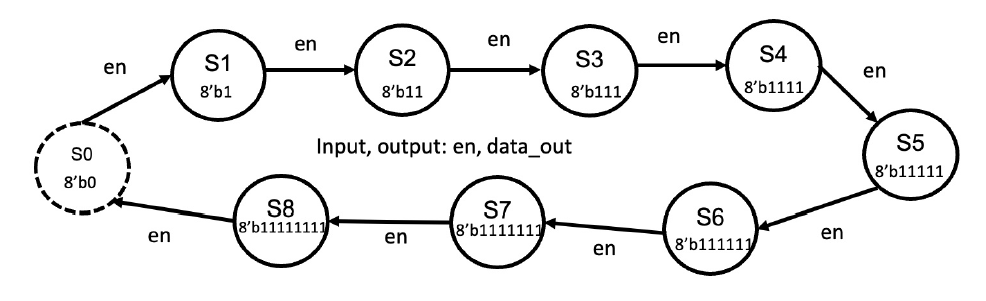

- The transition through states are controlled by `en` signal, which is controlled by `vbdFlag()` function. <br>

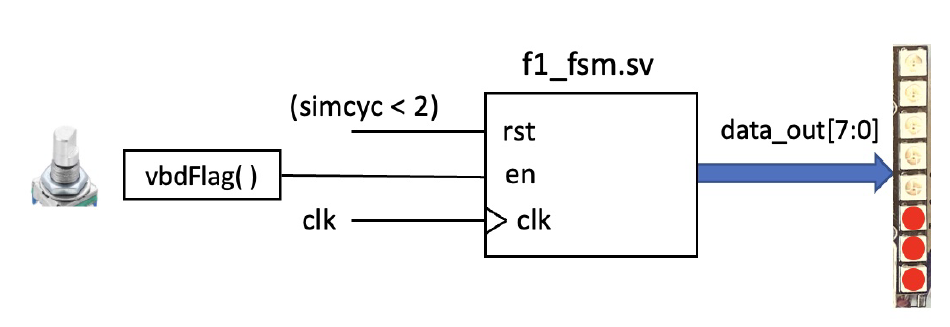

`f1_fsm.sv`
```systemverilog
module f1_fsm (
    input logic clk, 
    input logic en, 
    input logic rst, 
    output logic [7:0] data_out
); 

    typedef enum {S0, S1, S2, S3, S4, S5, S6, S7, S8} my_state; 
    my_state current_state, next_state;

    always_ff @(posedge clk, posedge rst) begin //state transition
        if (rst) current_state <= S0; 
        else current_state <= next_state;
    end

    always_comb // next state logic
        case (current_state)
            S0: if (en) next_state = S1; 
                else next_state = S0;
            S1: if (en) next_state = S2; 
                else next_state = S1;
            S2: if (en) next_state = S3; 
                else next_state = S2;
            S3: if (en) next_state = S4; 
                else next_state = S3;
            S4: if (en) next_state = S5; 
                else next_state = S4;
            S5: if (en) next_state = S6; 
                else next_state = S5;
            S6: if (en) next_state = S7; 
                else next_state = S6;
            S7: if (en) next_state = S8; 
                else next_state = S7;
            S8: if (en) next_state = S0; 
                else next_state = S8;
        endcase

    always_comb // output logic 
        case (current_state)
            S0: data_out = 8'b0;
            S1: data_out = 8'b1;
            S2: data_out = 8'b11;
            S3: data_out = 8'b111;
            S4: data_out = 8'b1111;
            S5: data_out = 8'b11111;
            S6: data_out = 8'b111111;
            S7: data_out = 8'b1111111;
            S8: data_out = 8'b11111111;
        endcase

endmodule

```

`testbench`
```c++
#include "verilated.h"
#include "verilated_vcd_c.h"
#include "Vf1_fsm.h"

#include "vbuddy.cpp"
#define MAX_SIM_CYC 1000000

int main(int argc, char **argv, char **env){
    int simcyc;                 //simulation clock count 
    int tick;                   //each clk cycle has two ticks for two edges

    Verilated::commandArgs(argc, argv);
    Vf1_fsm *top = new Vf1_fsm;
    Verilated::traceEverOn(true);
    VerilatedVcdC* tfp = new VerilatedVcdC;
    top->trace(tfp, 99);
    tfp->open("f1_fsm.vcd");


    if (vbdOpen()!=1)   return (-1);
    vbdHeader("L3T2: F1_FSM");
    vbdSetMode(1);

    top->clk = 1;
    top->rst = 0;
    top->en = 1;

    for (simcyc = 0; simcyc<MAX_SIM_CYC; simcyc++) {
        for (tick=0; tick<2; tick++){
            tfp->dump(2*simcyc+tick);
            top->clk = !top->clk;
            top->eval();
        }

        top->rst = (simcyc<2);
        top->en = vbdFlag(); 
        //display the four bit output on the 7-segment display
        vbdHex(1, top->data_out & 0xF);     
        vbdHex(2, (top->data_out >> 4) & 0xF);
        //display the 4-bit result on the neopixel strip 
        //using the vbdBar() function       
        vbdBar(top->data_out & 0xFF);       
        if ((Verilated::gotFinish()) || (vbdGetkey()=='q'))
            exit(0);
    }

    vbdClose();
    tfp->close();
    exit(0);
}
```

## Task 3 - Exploring the `clktick.sv` and the `delay.sv` modules

### Step 1 - Clocktick Module

> - In the task3 folder, `clktick_tb.cpp` and shell script `clktick.sh` is provided  to build and test the clktick module. 
> - The testbench flashes the neopixel strip LEDs on and off at a rate determined by N. Our goal is to calibrate the circuit to find what value of N gives us a tick period of 1 sec. (the difference is due to computer)
> - Determine the `vbdValue()` that displays the value of N which gives a tick period of 1 second. <br><br>
>  

- When **N is 48**, tick period is around 1 second.
- Which means, in 48 clock cycles, one second elapses. 

### Step 2 - Challenge

> Implement the following design by combining `clktick.sv` with `f1_fsm.sv` so that the F1 light sequence is cycle through automaticallly with 1 second delay per state transition. <br><br>
> 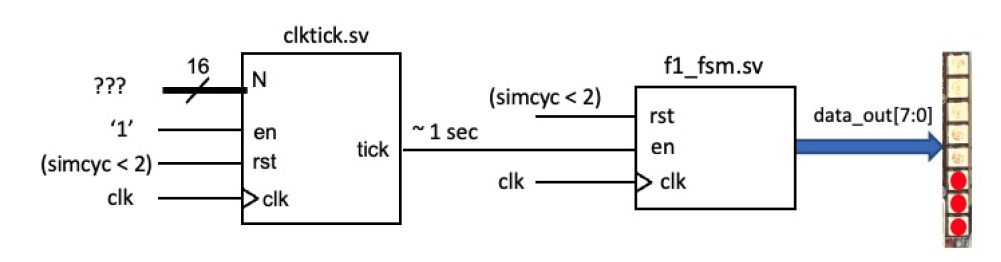

`auto_f1_fsm.sv`
```systemverilog
module auto_f1_fsm #(
    parameter WIDTH = 16
)(
    input logic                 clk, 
    input logic                 rst_tick, 
    input logic                 rst_fsm, 
    input logic                 en_tick, 
    input logic [WIDTH-1:0]     N, 
    output logic [7:0]          data_out

); 

    logic en_fsm; 

    clktick clock_tick(
        .clk(clk), 
        .rst(rst_tick), 
        .en(en_tick), 
        .N(N), 
        .tick(en_fsm)
    );

    f1_fsm auto_f1(
        .clk(clk), 
        .rst(rst_fsm), 
        .en(en_fsm), 
        .data_out(data_out)
    );

endmodule

```

`testbench`
```c++
#include "verilated.h"
#include "verilated_vcd_c.h"
#include "Vauto_f1_fsm.h"

#include "vbuddy.cpp"     // include vbuddy code
#define MAX_SIM_CYC 100000

int main(int argc, char **argv, char **env) {
  int simcyc;     // simulation clock count
  int tick;       // each clk cycle has two ticks for two edges
  int lights = 0; // state to toggle LED lights

  Verilated::commandArgs(argc, argv);
  // init top verilog instance
  Vauto_f1_fsm * top = new Vauto_f1_fsm;
  // init trace dump
  Verilated::traceEverOn(true);
  VerilatedVcdC* tfp = new VerilatedVcdC;
  top->trace (tfp, 99);
  tfp->open ("clktick.vcd");
 
  // init Vbuddy
  if (vbdOpen()!=1) return(-1);
  vbdHeader("L3T3 Challenge");
  vbdSetMode(1);        // Flag mode set to one-shot

  // initialize simulation inputs
  top->clk = 1;
  top->rst_tick = 0;
  top->rst_fsm = 0; 
  top->en_tick = 0;
  top->N = vbdValue(); 
  
  // run simulation for MAX_SIM_CYC clock cycles
  for (simcyc=0; simcyc<MAX_SIM_CYC; simcyc++) {
    // dump variables into VCD file and toggle clock
    for (tick=0; tick<2; tick++) {
      tfp->dump (2*simcyc+tick);
      top->clk = !top->clk;
      top->eval ();
    }

    // Display toggle neopixel
    vbdBar(top->data_out & 0xFF);
    // set up input signals of testbench
    top->rst_tick = (simcyc < 2);    // assert reset for 1st cycle
    top->rst_fsm = (simcyc < 2);     // assert reset for 1st cycle
    top->en_tick = (simcyc > 2);
    top->N = vbdValue();
    vbdCycle(simcyc);

    if (Verilated::gotFinish() || (vbdGetkey() == 'q'))  exit(0);
  }

  vbdClose();     // ++++
  tfp->close(); 
  exit(0);
}

```